# Time-translational-invariant (TTI) Dyson

$$
(i \partial_t - H - \Sigma^R \ast ) G^{tv} = \Sigma^{tv} \ast G^M
$$

$$
\Sigma^R(t) = \xi \Sigma^{tv}(t, \beta) - \Sigma^{tv}(t,  0)
$$

$$
G^{tv}(0, \tau) = -i G^M(\beta - \tau)
$$

In [2]:
using PyPlot; plt = PyPlot
using Keldysh; kd = Keldysh;

## Integral term $\Sigma^R \ast G^{tv}$

$$
\Sigma^R \ast G^{tv} = \int_0^t d\bar{t} \, \Sigma^R(t - \bar{t}) G^{tv}(\bar{t}, \tau) 
\approx 
\Delta t \sum_{j=1}^i'
\Sigma^R(t_i - t_j) G^{tv}(t_j, \tau)
$$

Separate out boundaries

$$ 
\Sigma^R \ast G^{tv} 
=
\frac{\Delta t}{2} \Sigma^R(0) G^{tv}(t_i, \tau) 
+
\Delta t \sum_{j=2}^{i-1} \Sigma^R(t_i - t_j) G^{tv}(t_j, \tau) 
+
\frac{\Delta t}{2} \Sigma^R(t_i) G^{tv}(0, \tau)
=
\frac{\Delta t}{2} \Sigma^R(0) G^{tv}(t_i, \tau) 
+ I(t_i, \tau)
$$


In [48]:
function get_R_from_tv(G, t)
    grid = G.grid
    τ0 = first(grid[imaginary_branch])
    τβ = last(grid[imaginary_branch])
    GR = Int(Σ.ξ) * G[:, :, t, τβ] - G[:, :, t, τ0]
    return GR
end;

In [49]:
function integrate_tti_retarded_trapz(Σ, G, t, τ)

    grid = G.grid
    dt = step(grid, forward_branch)
    
    t0 = first(grid[forward_branch])
    τ0 = first(grid[imaginary_branch])
    τβ = last(grid[imaginary_branch])
    
    norb = kd.norbitals(G)
    I = Array{ComplexF64}(undef, norb, norb)
    I .= 0.0

    if t.ridx == 1
        return I
    end
        
    #ΣR = Int(Σ.ξ) * Σ[:, :, t, τβ] - Σ[:, :, t, τ0]
    ΣR = get_R_from_tv(Σ, t)
    I += 0.5 * dt * ΣR * G[:, :, t0, τ]

    for tp in grid[forward_branch][2:t.ridx - 1]
        tmtp = grid[forward_branch][t.ridx - tp.ridx + 1]
        #ΣR = Int(Σ.ξ) * Σ[:, :, tmtp, τβ] - Σ[:, :, tmtp, τ0]
        ΣR = get_R_from_tv(Σ, tmtp)
        I += dt * ΣR * G[:, :, tp, τ]
    end
    
    return I
    
end;

### Test

Let $\Sigma^R(t) = e^{-i\omega_1 t}$ and $G^{tv}(t, \tau) = e^{-i \omega_2 t}$, then

$$
\int_0^t d\bar{t} \, \Sigma^R(t - \bar{t}) G^{tv}(\bar{t}, \tau)
=
e^{-i \omega_1 t} \int_0^t d\bar{t} \, e^{i (\omega_1 - \omega_2) \bar{t}}
=
\frac{-i}{\omega_1 - \omega_2} \left( e^{-i \omega_2 t} - e^{-i \omega_1 t} \right)
$$

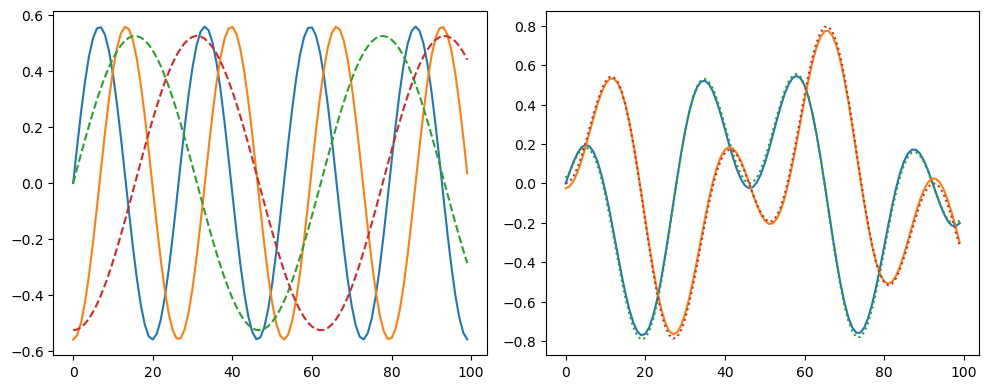

In [54]:
β = 0.1
ω1 = 1.0
ω2 = 2.35

tmax = 10.0

ntau = 16
nt = 100

c = kd.twist(kd.FullContour(tmax=tmax, β=β))
grid = kd.FullTimeGrid(c, nt, ntau);

dt = step(grid, forward_branch)
t0 = first(grid[forward_branch])

Σ = kd.TimeInvariantFullTimeGF(kd.DeltaDOS(ω1), grid);
G = kd.TimeInvariantFullTimeGF(kd.DeltaDOS(ω2), grid);
ΣG_ref = -1/(ω1 - ω2) * ( G - Σ )

function integrate(G, Σ)
    ΣG = kd.TimeInvariantFullTimeGF(grid)
    ΣR0 = get_R_from_tv(Σ, t0)
    for t in grid[forward_branch]
        for τ in grid[imaginary_branch]
            ΣG[:, :, t, τ] = integrate_tti_retarded_trapz(Σ, G, t, τ)
            ΣG[:, :, t, τ] +=  0.5 * dt * ΣR0 * G[:, :, t, τ]
        end
    end
    return ΣG
end

ΣG = integrate(G, Σ)

subp = [1, 2, 1]
plt.figure(figsize=(10, 4))

plt.subplot(subp...); subp[end] += 1
plt.plot(real(G.rm.data[1, 1, 1, :]))
plt.plot(imag(G.rm.data[1, 1, 1, :]))
plt.plot(real(Σ.rm.data[1, 1, 1, :]), "--")
plt.plot(imag(Σ.rm.data[1, 1, 1, :]), "--")

plt.subplot(subp...); subp[end] += 1
plt.plot(real(ΣG_ref.rm.data[1, 1, 1, :]), "-")
plt.plot(imag(ΣG_ref.rm.data[1, 1, 1, :]), "-")

plt.plot(real(ΣG.rm.data[1, 1, 1, :]), ":")
plt.plot(imag(ΣG.rm.data[1, 1, 1, :]), ":")

plt.tight_layout()

# Integral term: $\Sigma^{tv} \ast G$

$$
\Sigma^{tv} \ast G^M
=
\int_0^\beta d\bar{\tau} \, \Sigma^{tv}(t, \bar{\tau}) G^M(\bar{\tau} - \tau)
=
\int_0^\tau d\bar{\tau} \Sigma^{tv}(t, \bar{\tau}) \xi G^M(\beta + \bar{\tau} - \tau)
+
\int_\tau^\beta d\bar{\tau} \Sigma^{tv}(t, \bar{\tau}) G^M(\bar{\tau} - \tau)
= Q(t, \tau)
$$

In [55]:
function integrate_tti_mixed_trapz(Σ, G, t, τ)

    grid = G.grid
    dτ = -imag(step(grid, imaginary_branch))

    τ0 = first(grid[imaginary_branch])
    τβ = last(grid[imaginary_branch])
    
    norb = kd.norbitals(G)
    Q = Array{ComplexF64}(undef, norb, norb)
    Q .= 0.0
        
    # Trapz on the two continuous segments O(Δt^{-2})
        
    for τb in grid[imaginary_branch][τ0.ridx:τ.ridx]
        βpτbmτ = grid[imaginary_branch][τβ.ridx + τb.ridx - τ.ridx]
        s = τb.ridx == τ0.ridx || τb.ridx == τ.ridx ? 0.5 : 1.0
        Q += -im * s * dτ * Σ[:, :, t, τb] * Int(G.ξ) * G[:, :, βpτbmτ, τ0]
    end
        
    for τb in grid[imaginary_branch][τ.ridx:end]
        τbmτ = grid[imaginary_branch][τb.ridx - τ.ridx + 1]
        s = τb.ridx == τ.ridx || τb.ridx == τβ.ridx ? 0.5 : 1.0
        Q += -im * s * dτ * Σ[:, :, t, τb] * G[:, :, τbmτ, τ0]
    end
            
    # Rieman sum over discontinuity O(Δt^{-1})    
    #for τb in grid[imaginary_branch][τ0.ridx:τβ.ridx]
    #    Q += -im * dτ * Σ[:, :, t, τb] * G[:, :, τb, τ]
    #end

    return Q

end;

## Euler bwd
$$
i \partial_t G^{tv}(t_i, \tau_j) \approx \frac{i}{\Delta t} \left( G^{tv}(t_i, \tau_j) - G^{tv}(t_{i-1}, \tau_j) \right)
$$

$$
\left( \frac{i}{\Delta t} - H \right) G_0^{tv}(t_i, \tau_j) = \frac{i}{\Delta t} G_0^{tv}(t_{i-1}, \tau_j)
$$

## Implicit Trapezoidal

$$
w_{i+1} = w_i + \frac{h}{2} \left[ f_{i+1} + f_i \right]
$$

Ode form
$$
\partial_t y = f(t, y)
$$

Dyson rewritten
$$
i \partial_t G^{tv} = H G^{tv} + \Sigma^R \ast G^{tv} + \Sigma^{tv} \ast G^M
$$

## Full TTI Dyson discretization

$$
\left( \frac{i}{\Delta t} - H - \frac{\Delta t}{2} \Sigma^R(0) \right) G^{tv}(t_i, \tau) 
= 
\frac{i}{\Delta t} G^{tv}(t_{i-1}, \tau) 
+ I(t_i, \tau)
+ Q(t_i, \tau)
$$

In [56]:
using LinearAlgebra; la = LinearAlgebra

function timestep_tti_euler_bwd!(G, H, Σ, t, τ)

    grid = G.grid

    # -- Copy from imaginary time branch for t = 0
    
    if t.ridx == 1
        τ0 = first(grid[imaginary_branch])
        τβ = last(grid[imaginary_branch])
        βmτ = grid[imaginary_branch][τβ.ridx - τ.ridx + 1]
        G[:, :, t, τ] = Int(G.ξ) * G[:, :, βmτ, τ0]
        return
    end

    # -- Solve integrol diff Dyson eq. for t > 0
    
    I = integrate_tti_retarded_trapz(Σ, G, t, τ) # ΣR * Gtv
    Q = integrate_tti_mixed_trapz(Σ, G, t, τ) # Σtv * GM

    dt = step(grid, forward_branch)

    t0 = first(grid[forward_branch])
    tm1 = grid[forward_branch][t.ridx - 1] # Previous time

    τ0 = first(grid[imaginary_branch])
    τβ = last(grid[imaginary_branch])

    ΣR = Int(Σ.ξ) * Σ[:, :, t0, τβ] - Σ[:, :, t0, τ0]
    
    b = 1im/dt * G[:, :, tm1, τ] + I + Q    
    A = 1im/dt * la.I - H - 0.5 * dt * ΣR        

    G[:, :, t, τ] = A \ b
    
end;

In [57]:
using LinearAlgebra; la = LinearAlgebra

function timestep_tti_trapz_bwd!(G, H, Σ, t, τ)

    grid = G.grid

    # -- Copy from imaginary time branch for t = 0
    
    if t.ridx == 1
        τ0 = first(grid[imaginary_branch])
        τβ = last(grid[imaginary_branch])
        βmτ = grid[imaginary_branch][τβ.ridx - τ.ridx + 1]
        G[:, :, t, τ] = Int(G.ξ) * G[:, :, βmτ, τ0]
        return
    end

    # -- Solve integrol diff Dyson eq. for t > 0
    
    dt = step(grid, forward_branch)
    t0 = first(grid[forward_branch])
    tm1 = grid[forward_branch][t.ridx - 1] # Previous time
    τ0 = first(grid[imaginary_branch])
    τβ = last(grid[imaginary_branch])

    I = integrate_tti_retarded_trapz(Σ, G, t, τ) # ΣR * Gtv
    Im1 = integrate_tti_retarded_trapz(Σ, G, tm1, τ) # ΣR * Gtv
    
    Q = integrate_tti_mixed_trapz(Σ, G, t, τ) # Σtv * GM
    Qm1 = integrate_tti_mixed_trapz(Σ, G, tm1, τ) # Σtv * GM

    #b = 1im/dt * G[:, :, tm1, τ] + I + Q    
    #A = 1im/dt * la.I - H - 0.5 * dt * Σ[:, :, t0, τ]        

    ΣR = Int(Σ.ξ) * Σ[:, :, t0, τβ] - Σ[:, :, t0, τ0]
    
    b = 1im/dt * G[:, :, tm1, τ] + 0.5 * H * G[:, :, tm1, τ] + 0.5 * ( I + Im1 + Q + Qm1 ) 
    if t.ridx > 1
        b += 0.25 * dt * ΣR * G[:, :, tm1, τ]
    end
    A = 1im/dt * la.I - 0.5 * H - 0.25 * dt * ΣR

    G[:, :, t, τ] = A \ b
    
end;

In [58]:
function timestep_tti_euler_bwd!(G, H, Σ, t)
    for τ in G.grid[imaginary_branch]
        timestep_tti_euler_bwd!(G, H, Σ, t, τ)
    end
end;

function timestep_tti_trapz_bwd!(G, H, Σ, t)
    for τ in G.grid[imaginary_branch]
        timestep_tti_trapz_bwd!(G, H, Σ, t, τ)
    end
end;

## Single level test

In [59]:
function solve_one_level(nt, ntau, tmax, β, ϵ; euler=true)
    
    c = kd.twist(kd.FullContour(tmax=tmax, β=β))
    grid = kd.FullTimeGrid(c, nt, ntau);

    G_ref = kd.TimeInvariantFullTimeGF(kd.DeltaDOS(ϵ), grid);

    Σ = kd.TimeInvariantFullTimeGF(grid);
    G = kd.TimeInvariantFullTimeGF(grid);

    Σ.rm.data[:] .= 0.0
    G.mat.data[:] = G_ref.mat.data

    H = Array{ComplexF64}(undef, 1, 1)
    H[1, 1] = ϵ

    for t in grid[forward_branch][1:end]
        if euler
            timestep_tti_euler_bwd!(G, H, Σ, t)
        else
            timestep_tti_trapz_bwd!(G, H, Σ, t)
        end
    end

    err = maximum(abs.(G.rm.data - G_ref.rm.data))
    @show nt, ntau, err
    
    return err, G, G_ref
end;

(nt, ntau, err) = (100, 16, 0.24640218549278373)
(nt, ntau, err) = (100, 16, 0.005284380423745362)


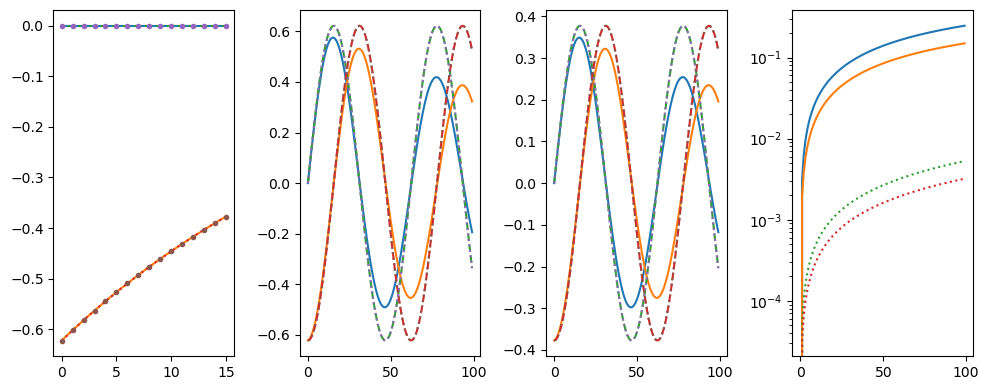

In [60]:
β = 0.5
t = 1.0
ϵ = 1.0

tmax = 10.0

ntau = 16
nt = 100 

errs, G, G_ref = solve_one_level(nt, ntau, tmax, β,  ϵ)
errs_trapz, G_trapz, G_ref_trapz = solve_one_level(nt, ntau, tmax, β,  ϵ; euler=false)

subp = [1, 4, 1]
plt.figure(figsize=(10, 4))

plt.subplot(subp...); subp[end] += 1
plt.plot(real(G.rm.data[1, 1, :, 1]))
plt.plot(imag(G.rm.data[1, 1, :, 1]))
plt.plot(real(G_ref.rm.data[1, 1, :, 1]), ":")
plt.plot(imag(G_ref.rm.data[1, 1, :, 1]), ":")
plt.plot(real(G_ref.mat.data[1, 1, :, 1]), ".")
plt.plot(imag(G_ref.mat.data[1, 1, :, 1]), ".")

plt.subplot(subp...); subp[end] += 1
plt.plot(real(G.rm.data[1, 1, 1, :]))
plt.plot(imag(G.rm.data[1, 1, 1, :]))
plt.plot(real(G_trapz.rm.data[1, 1, 1, :]), "--")
plt.plot(imag(G_trapz.rm.data[1, 1, 1, :]), "--")
plt.plot(real(G_ref.rm.data[1, 1, 1, :]), ":")
plt.plot(imag(G_ref.rm.data[1, 1, 1, :]), ":")

plt.subplot(subp...); subp[end] += 1
plt.plot(real(G.rm.data[1, 1, end, :]))
plt.plot(imag(G.rm.data[1, 1, end, :]))
plt.plot(real(G_trapz.rm.data[1, 1, end, :]), "--")
plt.plot(imag(G_trapz.rm.data[1, 1, end, :]), "--")
plt.plot(real(G_ref.rm.data[1, 1, end, :]), ":")
plt.plot(imag(G_ref.rm.data[1, 1, end, :]), ":")

plt.subplot(subp...); subp[end] += 1
plt.plot(abs.(G.rm.data[1, 1, 1, :] - G_ref.rm.data[1, 1, 1, :]))
plt.plot(abs.(G.rm.data[1, 1, end, :] - G_ref.rm.data[1, 1, end, :]))

plt.plot(abs.(G_trapz.rm.data[1, 1, 1, :] - G_ref.rm.data[1, 1, 1, :]), ":")
plt.plot(abs.(G_trapz.rm.data[1, 1, end, :] - G_ref.rm.data[1, 1, end, :]), ":")
plt.semilogy([], [])
plt.tight_layout()

(nt, ntau, err) = (2, 8, 0.18050942685343938)
(nt, ntau, err) = (4, 8, 0.07857326165280708)
(nt, ntau, err) = (8, 8, 0.036000440411876215)
(nt, ntau, err) = (16, 8, 0.0171902985379831)
(nt, ntau, err) = (32, 8, 0.008397094951979978)
(nt, ntau, err) = (64, 8, 0.004149723069547112)
(nt, ntau, err) = (128, 8, 0.002062748533245293)
(nt, ntau, err) = (2, 8, 0.03816009134658331)
(nt, ntau, err) = (4, 8, 0.004781460057969988)
(nt, ntau, err) = (8, 8, 0.0008900984340170141)
(nt, ntau, err) = (16, 8, 0.00019430721329123055)
(nt, ntau, err) = (32, 8, 4.551658514540297e-5)
(nt, ntau, err) = (64, 8, 1.1022074155303877e-5)
(nt, ntau, err) = (128, 8, 2.712372668027212e-6)


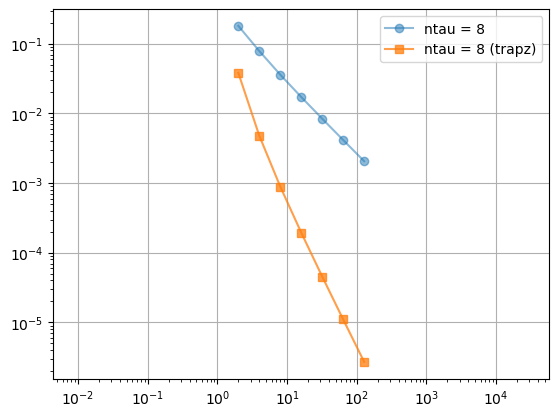

In [63]:
β = 0.1
t = 1.0
ϵ = 1.5

tmax = 1.0

ntau = 20
nts = 2 .^(1:7)
ntaus = [8]

errs_ntau = [ (ntau ,[solve_one_level(nt, ntau, tmax, β,  t)[1] for nt in nts]) for ntau in ntaus]
errs_ntau_trapz = [ (ntau ,[solve_one_level(nt, ntau, tmax, β,  t; euler=false)[1] for nt in nts]) for ntau in ntaus]

for (ntau, errs) in errs_ntau
    plt.plot(nts, errs, "o-", label="ntau = $ntau", alpha=0.5)
end

for (ntau, errs) in errs_ntau_trapz
    plt.plot(nts, errs, "s-", label="ntau = $ntau (trapz)", alpha=0.75)
end

if false
ntau, errs = last(errs_ntau)
line = errs[end] .* nts[end] ./ nts
plt.plot(nts, line, "k--", alpha=0.75)

ntau, errs = last(errs_ntau_trapz)
line = errs[end] .* nts[end] ./ nts
plt.plot(nts, line, "k--", alpha=0.75)
end

plt.legend(loc="best")
plt.loglog([], [])
plt.grid(true)
plt.axis("equal");

## Bethe lattice test

For $\Sigma$ equal to a semi-cicular spectral function (Bethe lattice) then the solution $G$ of the Dyson equation should have *exactly* the same form, up to discretization errors.

Here we use this property to study the convergence properties of the Dyson solver.

In [64]:
function solve_bethe(nt, ntau, tmax, β, t, ϵ; euler=true)
    
    c = kd.twist(kd.FullContour(tmax=tmax, β=β))
    grid = kd.FullTimeGrid(c, nt, ntau);

    Σ = kd.TimeInvariantFullTimeGF(kd.bethe_dos(t=t, ϵ=ϵ), grid);
    G = kd.TimeInvariantFullTimeGF(grid);

    G.mat.data[:] = Σ.mat.data

    H = Array{ComplexF64}(undef, 1, 1)
    H[1, 1] = ϵ

    for t in grid[forward_branch][1:end]
        if euler
            timestep_tti_euler_bwd!(G, H, Σ, t)
        else
            timestep_tti_trapz_bwd!(G, H, Σ, t)
        end
    end

    err = maximum(abs.(G.rm.data - Σ.rm.data))
    @show nt, ntau, err
    
    return err, G, Σ
end;

(nt, ntau, err) = (100, 16, 0.007197428900753661)
(nt, ntau, err) = (100, 16, 0.0007031531876859591)


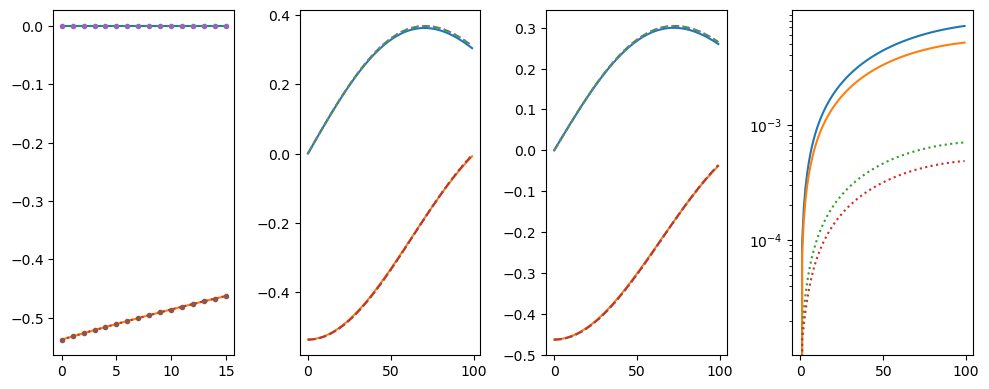

In [65]:
β = 0.1
t = 1.0
ϵ = 1.5

tmax = 1.0

ntau = 16
nt = 100 

errs, G, Σ = solve_bethe(nt, ntau, tmax, β,  t, ϵ)
errs_trapz, G_trapz, Σ_trapz = solve_bethe(nt, ntau, tmax, β,  t, ϵ; euler=false)

subp = [1, 4, 1]
plt.figure(figsize=(10, 4))

plt.subplot(subp...); subp[end] += 1
plt.plot(real(G.rm.data[1, 1, :, 1]))
plt.plot(imag(G.rm.data[1, 1, :, 1]))
plt.plot(real(Σ.rm.data[1, 1, :, 1]), ":")
plt.plot(imag(Σ.rm.data[1, 1, :, 1]), ":")
plt.plot(real(G.mat.data[1, 1, :, 1]), ".")
plt.plot(imag(G.mat.data[1, 1, :, 1]), ".")

plt.subplot(subp...); subp[end] += 1
plt.plot(real(G.rm.data[1, 1, 1, :]))
plt.plot(imag(G.rm.data[1, 1, 1, :]))
plt.plot(real(G_trapz.rm.data[1, 1, 1, :]), "--")
plt.plot(imag(G_trapz.rm.data[1, 1, 1, :]), "--")
plt.plot(real(Σ.rm.data[1, 1, 1, :]), ":")
plt.plot(imag(Σ.rm.data[1, 1, 1, :]), ":")

plt.subplot(subp...); subp[end] += 1
plt.plot(real(G.rm.data[1, 1, end, :]))
plt.plot(imag(G.rm.data[1, 1, end, :]))
plt.plot(real(G_trapz.rm.data[1, 1, end, :]), "--")
plt.plot(imag(G_trapz.rm.data[1, 1, end, :]), "--")
plt.plot(real(Σ.rm.data[1, 1, end, :]), ":")
plt.plot(imag(Σ.rm.data[1, 1, end, :]), ":")

plt.subplot(subp...); subp[end] += 1
plt.plot(abs.(G.rm.data[1, 1, 1, :] - Σ.rm.data[1, 1, 1, :]))
plt.plot(abs.(G.rm.data[1, 1, end, :] - Σ.rm.data[1, 1, end, :]))

plt.plot(abs.(G_trapz.rm.data[1, 1, 1, :] - Σ_trapz.rm.data[1, 1, 1, :]), ":")
plt.plot(abs.(G_trapz.rm.data[1, 1, end, :] - Σ_trapz.rm.data[1, 1, end, :]), ":")
plt.semilogy([], [])
plt.tight_layout()

(nt, ntau, err) = (2, 2, 0.2896332255595458)
(nt, ntau, err) = (4, 2, 0.1654523218157979)
(nt, ntau, err) = (8, 2, 0.08876024917218941)
(nt, ntau, err) = (16, 2, 0.04776360767245403)
(nt, ntau, err) = (32, 2, 0.02733234897268794)
(nt, ntau, err) = (64, 2, 0.017685636965323416)
(nt, ntau, err) = (2, 4, 0.2894030823310465)
(nt, ntau, err) = (4, 4, 0.16352493134804374)
(nt, ntau, err) = (8, 4, 0.08596204384900286)
(nt, ntau, err) = (16, 4, 0.0442892101419872)
(nt, ntau, err) = (32, 4, 0.023116718283398164)
(nt, ntau, err) = (64, 4, 0.012605857467696746)
(nt, ntau, err) = (2, 8, 0.28934146178407527)
(nt, ntau, err) = (4, 8, 0.16299319217849623)
(nt, ntau, err) = (8, 8, 0.08521488657521122)
(nt, ntau, err) = (16, 8, 0.04340983532806756)
(nt, ntau, err) = (32, 8, 0.022116870403460515)
(nt, ntau, err) = (64, 8, 0.011450996804550986)
(nt, ntau, err) = (2, 16, 0.2893173305540822)
(nt, ntau, err) = (4, 16, 0.16278290557014471)
(nt, ntau, err) = (8, 16, 0.08492286466393725)
(nt, ntau, err) = (16,

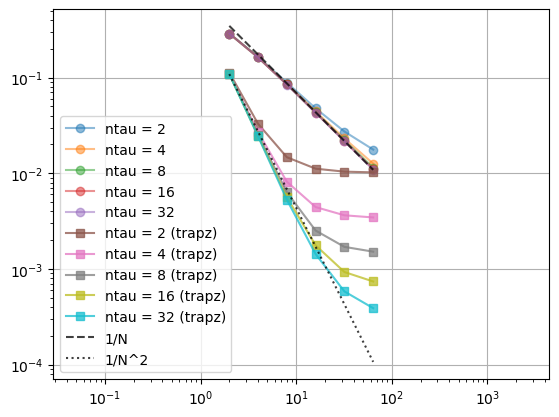

In [66]:
β = 0.1
t = 1.0
ϵ = 1.5

tmax = 1.0

ntau = 20
nts = 2 .^(1:6)
ntaus = [2, 4, 8, 16, 32]
#ntaus = [2, 4, 8]

errs_ntau = [ (ntau ,[solve_bethe(nt, ntau, tmax, β,  t, ϵ)[1] for nt in nts]) for ntau in ntaus]
errs_ntau_trapz = [ (ntau ,[solve_bethe(nt, ntau, tmax, β,  t, ϵ; euler=false)[1] for nt in nts]) for ntau in ntaus]

for (ntau, errs) in errs_ntau
    plt.plot(nts, errs, "o-", label="ntau = $ntau", alpha=0.5)
end

for (ntau, errs) in errs_ntau_trapz
    plt.plot(nts, errs, "s-", label="ntau = $ntau (trapz)", alpha=0.75)
end

ntau, errs = last(errs_ntau)
line = errs[end] .* nts[end] ./ nts
plt.plot(nts, line, "k--", alpha=0.75, label="1/N")

ntau, errs = last(errs_ntau_trapz)
line = errs[1] .* (nts[1] ./ nts).^2
plt.plot(nts, line, "k:", alpha=0.75, label="1/N^2")

plt.legend(loc="best")
plt.loglog([], [])
plt.grid(true)
plt.axis("equal");